C:\Apps\bin\envs\stan_env\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


                      ds      yhat  yhat_lower  yhat_upper
3067 2018-06-01 22:45:00  0.074790  -13.253832   12.102059
3068 2018-06-01 23:00:00 -0.019594  -11.970615   11.595092
3069 2018-06-01 23:15:00 -0.109268  -13.558132   11.870237
3070 2018-06-01 23:30:00 -0.189808  -13.386713   11.660161
3071 2018-06-01 23:45:00 -0.257362  -13.478959   13.012136


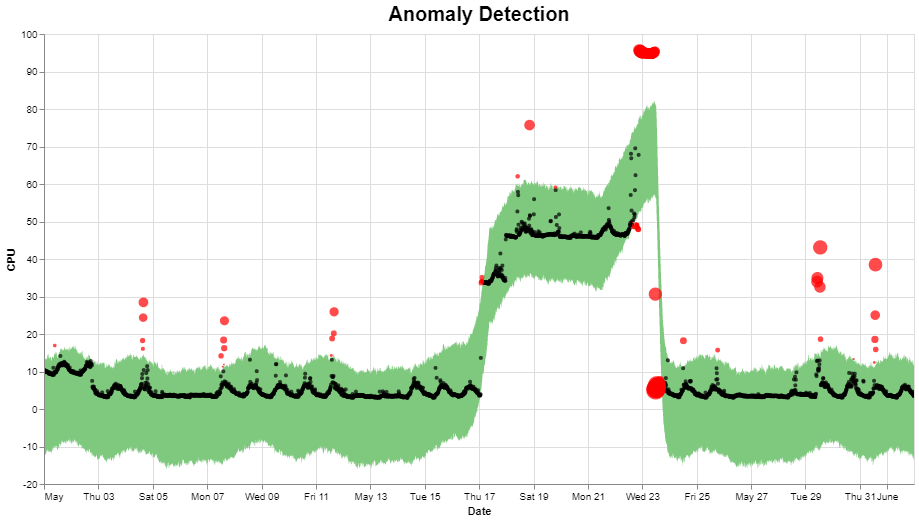

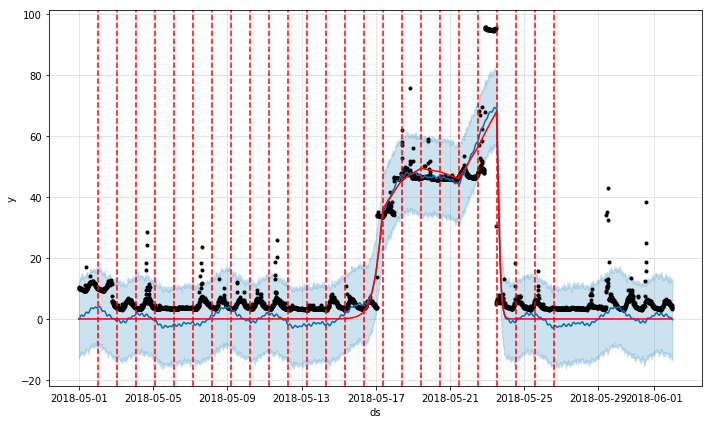

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 13 14:14:18 2019

@author: n375854
"""

import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric,add_changepoints_to_plot
import altair as alt
alt.renderers.enable('notebook')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['errorPrcnt'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'distance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])
    forecasted.loc[forecasted['anomaly'] ==-1, 'distance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])
    
    return forecasted

def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='Date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection With Prophet'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='CPU'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='CPU'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper', 'distance'],
        size = alt.Size( 'distance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              


#df = pd.read_csv('C:\Apps\SampleData_CPU.csv')
#print(df.head())
    
df = pd.read_json(r"C:\Projects\Prophet\input_data.json")
#df = df.loc[df['system_name'] == 'dx9p']

df['@timestamp'] = pd.to_datetime(df['@timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.sort_values(by='@timestamp')
#df = df[['@timestamp','cpu_busy']]
df = df[['@timestamp','busy_cpu']]
df.columns = ['ds','y']

df['ds'] = pd.to_datetime(df['ds'],errors='coerce')
df.set_index('ds',inplace=True)
df = df.resample('15min').mean()
df = df.reset_index()

df['cap'] = 100
df['floor'] = 0
#print(df.head())
#print(df.tail())


prophet = Prophet(changepoint_prior_scale=30,growth='logistic',
                  seasonality_prior_scale=10, interval_width=0.9)
#prophet = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
#                  growth='logistic'
#                  ).add_seasonality(name='weekly',period=7,fourier_order=20
#                  ).add_seasonality(name='daily',period=1,fourier_order=15)
prophet = prophet.fit(df)

#future = prophet.make_future_dataframe(periods=1,freq='15min')
#print(future.tail())
#future['cap'] = 100
#future['floor'] = 0

#forecast = prophet.predict(future)
forecast = prophet.predict(df)
forecast['fact'] = df['y'].reset_index(drop = True)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

forecast = detect_anomalies(forecast)

fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
#fig2 = prophet.plot_components(forecast)

plot_anomalies(forecast)

#df_cv = cross_validation(prophet,initial='25 days',horizon='20 hours',period='5 hours')

#mean aboslute percent error
#mape = mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
#print(mape)

#df_performance = performance_metrics(df_cv)#,rolling_window=0.5)
#print('HEAD', df_performance.head())
#print('TAIL', df_performance.tail())

#fig3 = plot_cross_validation_metric(df_cv, metric='mape')
